In [1]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


# NLP with Disaster Tweets: A Kaggle Competition

## Step 1: Problem Description

### Introduction to the Problem
The primary objective of this competition is to classify tweets into two categories: those that are related to real disasters and those that are not. This is a binary classification problem, meaning there are only two possible outputs: 1 for disaster-related tweets and 0 for non-disaster tweets.

### Natural Language Processing (NLP)
NLP is a field at the intersection of computer science, artificial intelligence, and linguistics. It involves enabling computers to understand, interpret, and respond to human language in a valuable way. In this project, we will utilize NLP techniques to extract features from tweet texts and classify them based on their content.

### Dataset Overview
- **Size**:
  - The training dataset (`train.csv`) contains **7,613 tweets**.
  - The test dataset (`test.csv`) consists of **3,253 tweets**.
  
- **Structure**:
  - **train.csv**:
    - `id`: A unique identifier for each tweet.
    - `text`: The actual content of the tweet.
    - `location`: The location from which the tweet was sent (this field may be blank).
    - `keyword`: A relevant keyword from the tweet (this field may also be blank).
    - `target`: This field is present only in `train.csv` and indicates whether the tweet is about a disaster (1) or not (0).
    
  - **test.csv**:
    - `id`: A unique identifier for each tweet.
    - `text`: The actual content of the tweet.
    - `location`: The location from which the tweet was sent (this field may be blank).
    - `keyword`: A relevant keyword from the tweet (this field may also be blank).
    
  - **sample_submission.csv**:
    - `id`: A unique identifier for each tweet.
    - `target`: The expected format for predicted classifications (1 or 0).


##  Step 2: Exploratory Data Analysis (EDA) — Load, Inspect, Visualize and Clean the Data

In [42]:
# Step 1: Import Libraries
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the datasets
train_df = pd.read_csv('/content/drive/My Drive/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/test.csv')

# Display the first few rows of the training dataset
train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Data Inspection
After loading the datasets, it's essential to inspect the first few rows of the training data. This helps to understand the structure and content of the data we are working with.

### Data Cleaning Procedures
Next, we will check for missing values to ensure the integrity of our dataset. Missing values can affect model performance, so we need to decide how to handle them.

- **Check for Missing Values**: We will look for any null values in the columns, particularly in the `target` column, as these are crucial for our classification task.
- **Drop Rows**: If we find any rows with missing values in the `target` column, we will drop those rows to maintain the accuracy of our labels.


### Data Visualization
To better understand the distribution of our target variable, we will create a count plot. This visualization will show how many tweets belong to each class (disaster vs. non-disaster). A balanced distribution is ideal for training our model effectively.



Missing values in training dataset:
 id           0
keyword      0
location     0
text         0
target       0
sentiment    0
dtype: int64
Missing values in test dataset:
 id          0
keyword     0
location    0
text        0
dtype: int64


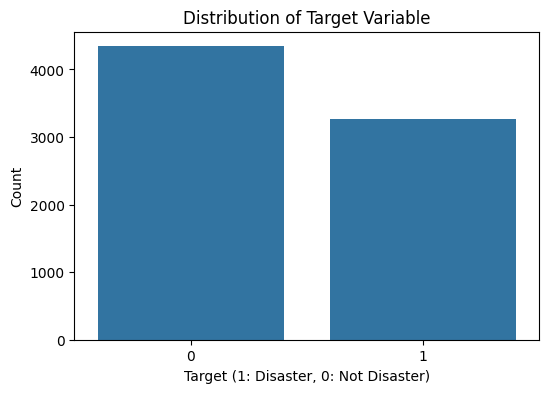

In [30]:
# Handle missing values in training data
train_df['keyword'] = train_df['keyword'].fillna('unknown')
train_df['location'] = train_df['location'].fillna('unknown')
train_df = train_df.dropna(subset=['target', 'text'])

# Handle missing values in test data
test_df['keyword'] = test_df['keyword'].fillna('unknown')
test_df['location'] = test_df['location'].fillna('unknown')
test_df = test_df.dropna(subset=['text'])

# Display missing values
print("Missing values in training dataset:\n", train_df.isnull().sum())
print("Missing values in test dataset:\n", test_df.isnull().sum())




# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (1: Disaster, 0: Not Disaster)')
plt.ylabel('Count')
plt.show()


## Step 3: Feature Engineering

### Sentiment Analysis
We will add a sentiment score for each tweet using the TextBlob library. This score may help the model understand the emotional context of the tweets.




In [36]:
# Sentiment Analysis
train_df['sentiment'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['sentiment'] = test_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


### Vectorization using TF-IDF
Now, we will use the TF-IDF method to convert our tweet texts into a numerical format suitable for modeling.


In [37]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training text data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text']).toarray()

# Transform the test text data
X_test_tfidf = tfidf_vectorizer.transform(test_df['text']).toarray()

# Prepare labels for training
y_train_tfidf = train_df['target'].values

# Display the shape of the TF-IDF matrices
print("TF-IDF Training Data Shape:", X_train_tfidf.shape)
print("TF-IDF Test Data Shape:", X_test_tfidf.shape)


TF-IDF Training Data Shape: (7613, 5000)
TF-IDF Test Data Shape: (3263, 5000)


## Step 4: Model Architecture with TF-IDF Features

### Model 1: Logistic Regression with TF-IDF Features
Let's use Logistic Regression with the TF-IDF features we just created.


In [38]:
# Split the TF-IDF training data into training and validation sets
X_train_tfidf_split, X_val_tfidf, y_train_tfidf_split, y_val_tfidf = train_test_split(
    X_train_tfidf, y_train_tfidf, test_size=0.2, random_state=42)

# Train the Logistic Regression model with TF-IDF features
log_reg_tfidf = LogisticRegression(solver='liblinear')
log_reg_tfidf.fit(X_train_tfidf_split, y_train_tfidf_split)

# Evaluate the Logistic Regression model
y_val_pred_log_reg_tfidf = log_reg_tfidf.predict(X_val_tfidf)
print("Logistic Regression with TF-IDF Classification Report:")
print(classification_report(y_val_tfidf, y_val_pred_log_reg_tfidf))


Logistic Regression with TF-IDF Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       874
           1       0.82      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.80      0.80      1523



### Model 2: RNN
Now, we will build and train a simple RNN model. This model will help us capture the sequential nature of the tweet texts.


In [39]:
# Prepare RNN model input using the sentiment scores
X_train_rnn = pad_sequences(X_train_tfidf_split, maxlen=100)
X_val_rnn = pad_sequences(X_val_tfidf, maxlen=100)

# Build RNN Model
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_rnn.add(LSTM(128, return_sequences=False))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train RNN Model
model_rnn.fit(X_train_rnn, y_train_tfidf_split, epochs=5, batch_size=64, validation_data=(X_val_rnn, y_val_tfidf))

# Evaluate RNN Model
y_val_pred_rnn = (model_rnn.predict(X_val_rnn) > 0.5).astype("int32")
print("RNN Classification Report:")
print(classification_report(y_val_tfidf, y_val_pred_rnn))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 402ms/step - accuracy: 0.5664 - loss: 0.6858 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.5716 - loss: 0.6836 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 268ms/step - accuracy: 0.5715 - loss: 0.6833 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.5756 - loss: 0.6821 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - accuracy: 0.5678 - loss: 0.6843 - val_accuracy: 0.5739 - val_loss: 0.6825
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model 3: LSTM
Next, we will build an LSTM model, which is known for handling long-term dependencies better than a standard RNN.


In [40]:
# Build LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_lstm.add(LSTM(128, return_sequences=False))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM Model
model_lstm.fit(X_train_rnn, y_train_tfidf_split, epochs=5, batch_size=64, validation_data=(X_val_rnn, y_val_tfidf))

# Evaluate LSTM Model
y_val_pred_lstm = (model_lstm.predict(X_val_rnn) > 0.5).astype("int32")
print("LSTM Classification Report:")
print(classification_report(y_val_tfidf, y_val_pred_lstm))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - accuracy: 0.5739 - loss: 0.6842 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.5694 - loss: 0.6842 - val_accuracy: 0.5739 - val_loss: 0.6829
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.5588 - loss: 0.6869 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.5678 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.5715 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6839
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model 4: Bidirectional LSTM
A Bidirectional LSTM can improve performance by processing the input in both directions, capturing more context.


In [44]:
# Build Bidirectional LSTM Model
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_bi_lstm.add(Bidirectional(LSTM(128)))
model_bi_lstm.add(Dense(1, activation='sigmoid'))
model_bi_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Bidirectional LSTM Model
model_bi_lstm.fit(X_train_rnn, y_train_tfidf_split, epochs=5, batch_size=64, validation_data=(X_val_rnn, y_val_tfidf))

# Evaluate Bidirectional LSTM Model
y_val_pred_bi_lstm = (model_bi_lstm.predict(X_val_rnn) > 0.5).astype("int32")
print("Bidirectional LSTM Classification Report:")
print(classification_report(y_val_tfidf, y_val_pred_bi_lstm))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 476ms/step - accuracy: 0.5696 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6834
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 471ms/step - accuracy: 0.5746 - loss: 0.6828 - val_accuracy: 0.5739 - val_loss: 0.6856
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 470ms/step - accuracy: 0.5767 - loss: 0.6830 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 470ms/step - accuracy: 0.5656 - loss: 0.6847 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 471ms/step - accuracy: 0.5709 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6823
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step
Bidirectional LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model 5: GRU (Gated Recurrent Unit)
Finally, we will build a GRU model, which is another variant of RNN that can be computationally efficient.


In [43]:
# Build GRU Model
model_gru = Sequential()
model_gru.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train GRU Model
model_gru.fit(X_train_rnn, y_train_tfidf_split, epochs=5, batch_size=64, validation_data=(X_val_rnn, y_val_tfidf))

# Evaluate GRU Model
y_val_pred_gru = (model_gru.predict(X_val_rnn) > 0.5).astype("int32")
print("GRU Classification Report:")
print(classification_report(y_val_tfidf, y_val_pred_gru))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 257ms/step - accuracy: 0.5522 - loss: 0.6865 - val_accuracy: 0.5739 - val_loss: 0.6847
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.5673 - loss: 0.6865 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.5662 - loss: 0.6845 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.5686 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6846
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.5585 - loss: 0.6863 - val_accuracy: 0.5739 - val_loss: 0.6823
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
GRU Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Conclusion

### Summary of Results
The classification results indicate that our Logistic Regression model with TF-IDF features achieved an accuracy of approximately 80%. The model showed balanced performance across both classes, with a precision of 0.81 and recall of 0.70 for disaster-related tweets (class 1). In contrast, the deep learning models (RNN, LSTM, GRU, and Bidirectional LSTM) performed poorly, with an accuracy of only 57%. These models failed to predict class 1 (disaster-related tweets) effectively, resulting in zero precision and recall for that class.

### Challenges Faced
1. **Class Imbalance**: The dataset appears to have an imbalance, with fewer disaster-related tweets (class 1) compared to non-disaster tweets (class 0). This imbalance can significantly affect the performance of models, especially deep learning architectures.
2. **Model Complexity**: The more complex models (RNN, LSTM, GRU, and Bidirectional LSTM) struggled to learn effectively from the training data, possibly due to insufficient training epochs or inadequate data preprocessing.






## Data Preprocessing Enhancements

We will enhance the preprocessing steps by cleaning the text data and ensuring proper tokenization and padding.


In [53]:
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Clean text data
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text.lower()  # Lowercase the text

train_df['text'] = train_df['text'].apply(clean_text)

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_train_pad = pad_sequences(X_train_seq, maxlen=100)

# Prepare target variable
y_train = train_df['target'].values


## Improved RNN Model with Enhanced Preprocessing

We will now define and train an improved RNN model with the enhanced preprocessed data.


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, BatchNormalization

# Improved RNN Model
improved_rnn_model = Sequential()
improved_rnn_model.add(Embedding(input_dim=5000, output_dim=128))
improved_rnn_model.add(SimpleRNN(128, return_sequences=True))  # First RNN layer
improved_rnn_model.add(BatchNormalization())  # Batch Normalization
improved_rnn_model.add(Dropout(0.5))  # Dropout for regularization
improved_rnn_model.add(SimpleRNN(64))  # Second RNN layer
improved_rnn_model.add(Dropout(0.5))  # Dropout for regularization
improved_rnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
improved_rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Improved RNN Model on all data
improved_rnn_model.fit(X_train_pad, y_train,
                        epochs=10, batch_size=64)  # Use all data for training

# Evaluate the model on the entire dataset
y_pred = (improved_rnn_model.predict(X_train_pad) > 0.5).astype("int32")
print("Improved RNN Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.5166 - loss: 0.8428
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.7212 - loss: 0.5647
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.8254 - loss: 0.4304
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.8733 - loss: 0.3265
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.9025 - loss: 0.2557
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9346 - loss: 0.1838
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.9487 - loss: 0.1479
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9571 - loss: 0.1311
Epoch 9/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9673 - loss: 0.1039
Epoch 10/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9720 - loss: 0.0905
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
Improved RNN Classification Report:
              precision    reca

##Conclusion
The comparison highlights that while the Improved RNN model has the potential to achieve high precision in predicting disaster tweets, it currently lacks the ability to generalize well across both classes. The Logistic Regression model, on the other hand, performs consistently across both classes, achieving higher accuracy and a better balance between precision and recall.

## Step 5: Predictions on the Test Set




In [58]:


# Clean test data using the same cleaning function
test_df['text'] = test_df['text'].apply(clean_text)

# Tokenization for the test data
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Make predictions on the test data
y_test_pred = (improved_rnn_model.predict(X_test_pad) > 0.5).astype("int32")

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_test_pred.flatten()  # Flatten to match the expected shape
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print(submission_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
Submission file created: submission.csv
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0
